In [5]:
from pyhive import hive
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import trange, tqdm
tqdm.pandas()
import datetime
from functools import reduce

In [6]:
# Connect to Hadoop database
conn = hive.Connection(host = 'hadoop.rcc.uchicago.edu', 
                       port = 10000, 
                       username = 'bowenliao', 
                       database = 'dmp_yelp_rs')
cursor = conn.cursor()

# Objective: 
Dimension modeling

In [4]:
# List tables
query = 'SHOW tables' #SQL
cursor.execute(query)
cursor.fetchall()

[('business_ambience',),
 ('business_attributes',),
 ('business_basicdata',),
 ('business_bestnights',),
 ('business_businessparking',),
 ('business_dietaryrestrictions',),
 ('business_goodformeal',),
 ('business_hairspecializesin',),
 ('business_music',),
 ('checkin',),
 ('geo_features',),
 ('review',),
 ('tip',),
 ('ts_features',),
 ('users',)]

In [13]:
cursor.description

[('review.business_id', 'STRING_TYPE', None, None, None, None, True),
 ('review.user_id', 'STRING_TYPE', None, None, None, None, True),
 ('review.stars', 'DOUBLE_TYPE', None, None, None, None, True)]

In [151]:
# Get data from basic data table and store into data frame, extracting category
query = 'select * from business_basicdata'
cursor.execute(query)
res = cursor.fetchall()
df = pd.DataFrame(res, columns = [i[0].split('.')[1] for i in cursor.description])
df.head()
data = df.copy()
category = pd.DataFrame(index=data.business_id)
data.fillna('',inplace=True)

In [189]:
# Checking if category is NA
df.categories.isna()

0        False
1        False
2        False
3        False
4        False
         ...  
63893    False
63894    False
63895    False
63896    False
63897    False
Name: categories, Length: 63898, dtype: bool

In [202]:
# Get a set of Categories
temp = [set([i.strip() for i in cat_list[0].split(',')]) 
            for cat_list in data[['categories']].dropna().values ]
CATs = reduce(set.__or__,temp)
CATs.remove('Restaurants')
CATs.remove('Food')
CATs.remove('')
len(CATs)

866

In [203]:
# Adding cleaned category to data frame
for cat in tqdm(CATs):
    encoding = ([cat in cat_list.strip() for cat_list in data.categories.values ])
    try:
        category[cat] = encoding 
    except:
        print(cat)

  0%|          | 0/866 [00:00<?, ?it/s]

In [205]:
# Create data frame from category + count of category, sorted by count descending 
Categories = pd.DataFrame({'Category':list(category.sum().keys()),'Count':category.sum().values}).sort_values('Count',ascending=False)

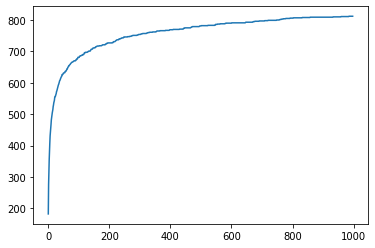

In [220]:
# Adding plot of sums of category counts less than different thresholds
_Lst = []
for h in range(2,1000):
    _Lst.append(sum(Categories.Count < h ))
plt.plot(_Lst)

In [240]:
#Keeping only the frequent categories
category_cleaned = category.drop(list(Categories[Categories.Count < 20].Category)+[""],axis = 1) 

In [246]:
# Value counts of cleaned categories sums
category_cleaned.sum().sort_values(ascending = False)

Bars                      12451
Nightlife                  9115
Coffee & Tea               7728
Sandwiches                 7271
American (Traditional)     6541
                          ...  
Head Shops                   21
Bartenders                   20
Shanghainese                 20
Olive Oil                    20
Coffee & Tea Supplies        20
Length: 330, dtype: int64

In [248]:
# Save to csv
category_cleaned.to_csv('df_major_category.csv')

# Combine other features

In [253]:
# List tables
query = 'SHOW tables' #SQL
cursor.execute(query)
cursor.fetchall()

[('business_ambience',),
 ('business_attributes',),
 ('business_basicdata',),
 ('business_bestnights',),
 ('business_businessparking',),
 ('business_dietaryrestrictions',),
 ('business_goodformeal',),
 ('business_hairspecializesin',),
 ('business_music',),
 ('checkin',),
 ('geo_features',),
 ('review',),
 ('tip',),
 ('ts_features',),
 ('users',)]

In [259]:
# Getting data from business attributes table and storing in data frame
query = 'select * from business_attributes'
cursor.execute(query)
res = cursor.fetchall()
df_business_attributes = pd.DataFrame(res, columns = [i[0].split('.')[1] for i in cursor.description])
df_business_attributes.head()

,business_id,restaurantstableservice,wifi,bikeparking,businessacceptscreditcards,restaurantsreservations,wheelchairaccessible,caters,outdoorseating,restaurantsgoodforgroups,...,goodfordancing,byob,coatcheck,smoking,drivethru,byobcorkage,corkage,restaurantscounterservice,agesallowed,open24hours
0,6iYb2HFDywm3zjuRg0shjw,True,free,True,True,False,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
1,tCbdrRPZA0oiIYSmHG3J0w,False,free,False,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,D4JtQNTI4X3KcbzacDJsMw,False,no,True,False,True,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
3,jFYIsSb7r1QeESVUnXPHBw,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,rYs_1pNB_RMtn5WQh55QDA,False,False,True,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [258]:
# Getting data from business best nights table and storing in data frame 
query = 'select * from business_bestnights'
cursor.execute(query)
res = cursor.fetchall()
df_best_night = pd.DataFrame(res, columns = [i[0].split('.')[1] for i in cursor.description])
df_best_night.head()

,business_id,friday,monday,saturday,sunday,thursday,tuesday,wednesday
0,NRPemqVb4qpWFF0Avq_6OQ,True,False,True,False,False,False,True
1,xSLdQjPgMhBrNIEtUgdWUA,True,False,False,False,True,False,False
2,Pk4ZwXwUU50BDn5gqw_rKg,False,True,False,False,False,False,False
3,9Bt9MMtmjPB6IykEMrFB7A,True,False,True,False,True,False,False
4,FJ-r3hOMbcq0p7Z5yH9oew,True,False,False,False,False,False,False


In [267]:
# Getting data from geographical features table and storing in data frame
query = 'select * from geo_features'
cursor.execute(query)
res = cursor.fetchall()
df_geo = pd.DataFrame(res, columns = [i[0].split('.')[1] for i in cursor.description])
df_geo.head()

,business_id,hhi,total_review,avg_stars,most_category,within__2_km,within__5_km,within__10_km
0,HPA_qyMEddpAEtFof02ixg,968.8581314878892,4396,3.3455882352941178,American,67,67,67
1,hcRxdDg7DYryCxCoI8ySQA,772.8981290747313,117373,3.4660138248847927,American,867,867,867
2,jGennaZUr2MsJyRhijNBfA,1679.5523356401388,31405,3.338235294117647,American,271,271,271
3,iPD8BBvea6YldQZPHzVrSQ,959.1058514135444,246738,3.4926739926739927,American,1364,1364,1364
4,Z2JC3Yrz82kyS86zEVJG5A,837.5,2491,3.25,Indian,39,39,39


In [277]:
# Filtering data for certain columns and joining on geo features, best night, business attributes, categories cleaned
df_biz_big = data[['business_id','city','state','stars','review_count','is_open']]
df_biz_big = df_biz_big.set_index('business_id').join(df_geo.set_index('business_id'))
df_biz_big = df_biz_big.join(df_best_night.set_index('business_id'))
df_biz_big = df_biz_big.join(df_business_attributes.set_index('business_id'))
df_biz_big = df_biz_big.join(category_cleaned)

In [284]:
# Saving to csv
df_biz_big.to_csv('BIZ_table.csv')

In [296]:
df_ts['ts_id'] = df_ts.index # Introduce new id

In [310]:
df_ts.head()

,month_year,simplified_category,seasonal_review_counts,trend_review_counts,residual_review_counts,seasonal_avg_stars,trend_avg_stars,residual_avg_stars,review_counts,avg_stars,is_pre_covid,ts_id
0,2004-10,Mediterranean,-10.937046615642585,-1.2397533022533085,17.17679991789589,0.046367529315388,3.719984006307916,0.2336484643766958,5.0,4.0,1,0
1,2004-11,Mediterranean,-65.4596624801703,-0.0818278943279002,68.5414903744982,0.0570819578537584,3.744277511391071,0.6986405307551709,3.0,4.5,1,1
2,2004-12,Mediterranean,-78.3597293250901,1.076097513597508,78.2836318114926,0.1128135378488343,3.7685710164742257,1.11861544567694,1.0,5.0,1,2
3,2005-01,Mediterranean,31.47304696724491,2.234022921522916,-32.707069888767826,0.0117708047021475,3.79286452155738,0.5953646737404725,1.0,4.4,1,3
4,2005-02,Mediterranean,-16.314887703272383,3.3919483294483244,13.92293937382406,-0.0362871630830976,3.817158026640535,0.0191291364425627,1.0,3.8,1,4


In [366]:
# Function to find time series id
def find_tsid(my,cat):
#     print(monthyear_catgory)
#     my,cat = monthyear_catgory['month_year'],monthyear_catgory['b.simplified_category']
    try:
        return df_ts[['month_year','simplified_category','ts_id']].query(f'month_year == "{my}" and simplified_category == "{cat}"').ts_id
    except Exception as e :
        print(e)
        return 5756

In [303]:
# query = """SELECT r.business_id, review_id, b.simplified_category,r.`date`
# FROM review r LEFT JOIN business_basicdata b
#     ON b.business_id = r.business_id"""
# cursor.execute(query)
# res = cursor.fetchall()
#temp = pd.DataFrame(res, columns = [i[0].split('.')[1] for i in cursor.description])
temp = pd.read_csv('ID_Dates.csv') #Alternative
temp.head()

,r.business_id,review_id,b.simplified_category,r.date
0,F0-yprYm7Pz5sw8WQLix0w,iQooOsfb8g6Mn70Wjc-n7w,NaN,2014-05-21 20:11:25
1,s5PTCyZGH5QGbVCnVdb6KA,mkPsNBi6wtpg8bKGehFKiQ,Italian,2009-12-24 03:07:25
2,y9DmwlwW1TuEQWv9vfqp8Q,_4cPF6h8fxVQClc3OYSGsA,American,2010-06-29 18:17:17
3,emWWcSEYCEVdfbpoQh313Q,HpghPCfQvoRFAgADR2jBHQ,Korean,2017-05-24 17:14:09
4,JU5tc609qMwV-jyIXm39Dg,wgkUxpXbm4oXSUz8AfBfuA,NaN,2013-12-06 15:24:45


In [314]:
# Function to return month-year
def Month_year(DT_str):
    return DT_str.split(' ')[0][:7]

In [324]:
# Applying month-year function
temp['month_year'] = temp['r.date'].apply(Month_year)

In [369]:
#Collect my_cat_id
out = []
for my,cat in tqdm(zip(temp['month_year'],temp['b.simplified_category']),total = temp.shape[0]):
    out.append(find_tsid(my,cat))

  0%|          | 0/100000 [00:00<?, ?it/s]

In [359]:
# Filter for certain columns and get first 10 and the items
temp[['month_year','b.simplified_category']][:10].items()

<generator object DataFrame.items at 0x7fcedc39a850>

In [305]:
temp['r.date']

0        2014-05-21 20:11:25
1        2009-12-24 03:07:25
2        2010-06-29 18:17:17
3        2017-05-24 17:14:09
4        2013-12-06 15:24:45
                ...         
99995    2014-08-24 04:32:28
99996    2012-01-25 13:25:18
99997    2017-05-25 23:10:56
99998    2012-08-14 18:52:04
99999    2011-05-26 19:09:24
Name: r.date, Length: 100000, dtype: object

# Agg User related data

In [29]:
# Describe users table
query = 'DESCRIBE users'
cursor.execute(query)
res = cursor.fetchall()

TProtocolException: invalid TType

In [27]:
# Get data from users table and store in data frame
query = 'select * from users'
cursor.execute(query)
res = cursor.fetchall()
df_business_attributes = pd.DataFrame(res, columns = [i[0].split('.')[1] for i in cursor.description])
df_business_attributes.head()

KeyboardInterrupt: 

In [15]:
# Get data from new additional time series features table and store in data frame
query = 'select * from ts_features_new'
cursor.execute(query)
res = cursor.fetchall()
df_ts = pd.DataFrame(res, columns = [i[0].split('.')[1] for i in cursor.description])
df_ts.head()

,business_id,pre_covid_avg_stars,pre_covid_review_count,post_covid_avg_stars,post_covid_review_count,last_7_avg_stars,last_7_review_count,last_30_avg_stars,last_30_review_count
0,--164t1nclzzmca7eDiJMw,3.8762626262626254,147.0,,,,,,
1,--6COJIAjkQwSUZci_4PJQ,4.111111111111111,102.0,,,,,,
2,--UNNdnHRhsyFUbDgumdtQ,4.38943816698054,1246.0,4.578947368421052,20.0,,,,
3,--_nBudPOb1lNRgKfjLtrw,3.7857142857142856,8.0,,,,,,
4,--bbZa1KPYSmW0X4o3TUQw,4.181818181818182,45.0,4.0,2.0,,,,


In [18]:
# Read back in earlier csv
df_biz_big = pd.read_csv('BIZ_table.csv',index_col=0)

In [21]:
# Join with new TS features
df_biz_big = df_biz_big.join(df_ts.set_index('business_id'))

In [25]:
# Value counts of states
df_biz_big.state.value_counts()

MA              13499
BC               9563
FL               9529
OR               9366
GA               7477
TX               6978
OH               5318
CO               1133
WA               1025
NH                  2
 Restaurants        1
KY                  1
KS                  1
DE                  1
MN                  1
VA                  1
ABE                 1
WY                  1
Name: state, dtype: int64

In [26]:
# Resave to csv
df_biz_big.to_csv('BIZ_table.csv')

# Attempting to create new database 

In [30]:
# List tables
query = 'SHOW tables' #SQL
cursor.execute(query)
cursor.fetchall()

KeyboardInterrupt: 

In [12]:
# Test ddl for creating table
ddl = """
CREATE TABLE Persons (
    PersonID int,
    LastName varchar(255),
    FirstName varchar(255),
    Address varchar(255),
    City varchar(255)
);"""
cursor.execute(query)
cursor.fetchall()
conn.commit()

In [13]:
# Re-listing tables
query = 'SHOW tables' #SQL
cursor.execute(query)
cursor.fetchall()

[('business_ambience',),
 ('business_attributes',),
 ('business_basicdata',),
 ('business_bestnights',),
 ('business_businessparking',),
 ('business_dietaryrestrictions',),
 ('business_goodformeal',),
 ('business_hairspecializesin',),
 ('business_music',),
 ('checkin',),
 ('geo_features',),
 ('review',),
 ('tip',),
 ('ts_features',),
 ('ts_features_new',),
 ('users',)]